
# Time Series Forecasting Project
### ARIMA and Exponential Smoothing Models


In [1]:

import os
import json
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import joblib

from statsmodels.tsa.holtwinters import Holt


## Utility Functions

In [2]:

def create_directories():
    folders = [
        "models",
        "results",
        "results/plots",
        "results/metrics",
        "results/forecasts"
    ]
    for folder in folders:
        os.makedirs(folder, exist_ok=True)

def save_plot(path):
    os.makedirs(os.path.dirname(path), exist_ok=True)

create_directories()


## Load Dataset

In [3]:

def load_exchange_rate(filepath="data/exchange_rate.csv"):
    df = pd.read_csv(filepath)
    df["date"] = pd.to_datetime(df["date"], dayfirst=True)
    df = df.set_index("date").sort_index()
    return df

df = load_exchange_rate()
column_name = "Ex_rate"


## Data Preprocessing

In [4]:

df = df.ffill().bfill()

mean_val = df[column_name].mean()
std_val = df[column_name].std()

df[column_name] = df[column_name].clip(
    lower=mean_val - 3 * std_val,
    upper=mean_val + 3 * std_val
)


## Visualization

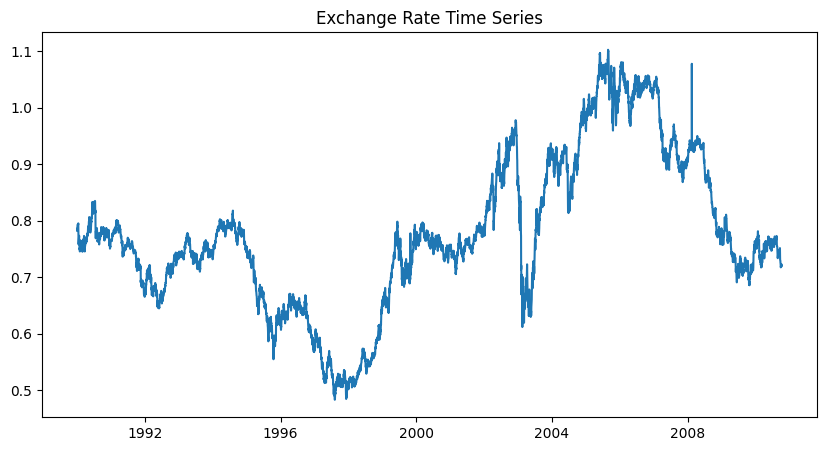

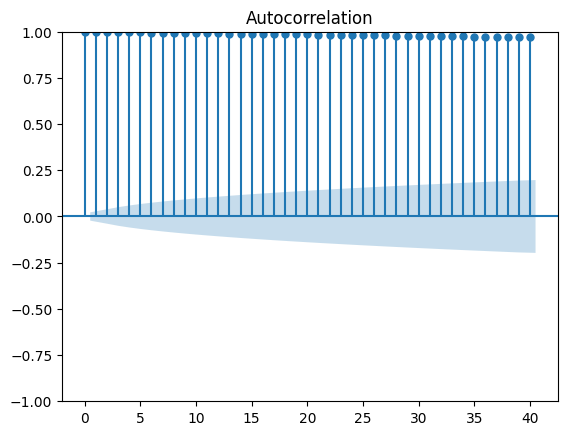

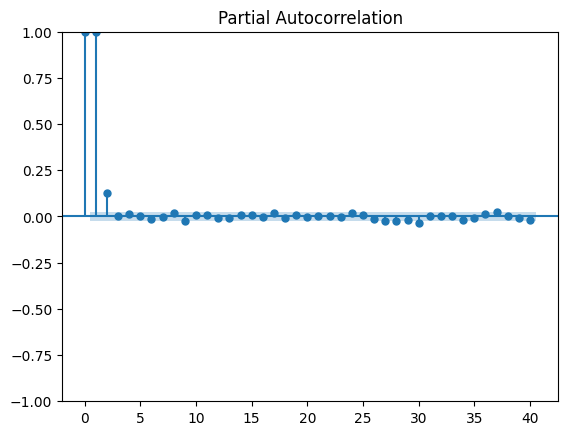

In [5]:

save_plot("results/plots/time_series.png")
plt.figure(figsize=(10,5))
plt.plot(df[column_name])
plt.title("Exchange Rate Time Series")
plt.savefig("results/plots/time_series.png")
plt.show()
plt.close()

save_plot("results/plots/acf.png")
sm.graphics.tsa.plot_acf(df[column_name], lags=40)
plt.savefig("results/plots/acf.png")
plt.show()
plt.close()

save_plot("results/plots/pacf.png")
sm.graphics.tsa.plot_pacf(df[column_name], lags=40, method="ywm")
plt.savefig("results/plots/pacf.png")
plt.show()
plt.close()


## ARIMA Model

c:\Users\pndin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\pndin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\pndin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


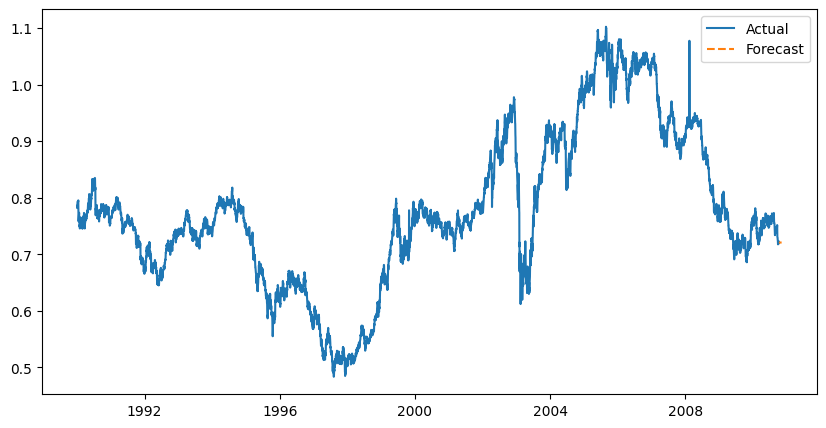

In [6]:

arima_model = sm.tsa.ARIMA(df[column_name], order=(1,1,1)).fit()
joblib.dump(arima_model, "models/arima_model.pkl")

arima_forecast = arima_model.forecast(30)
arima_df = pd.DataFrame({"Forecast": arima_forecast})
arima_df.to_csv("results/forecasts/arima_forecast.csv")

plt.figure(figsize=(10,5))
plt.plot(df[column_name], label="Actual")
plt.plot(arima_df["Forecast"], label="Forecast", linestyle="--")
plt.legend()
plt.savefig("results/plots/arima_forecast.png")
plt.show()
plt.close()


## Exponential Smoothing Model

c:\Users\pndin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


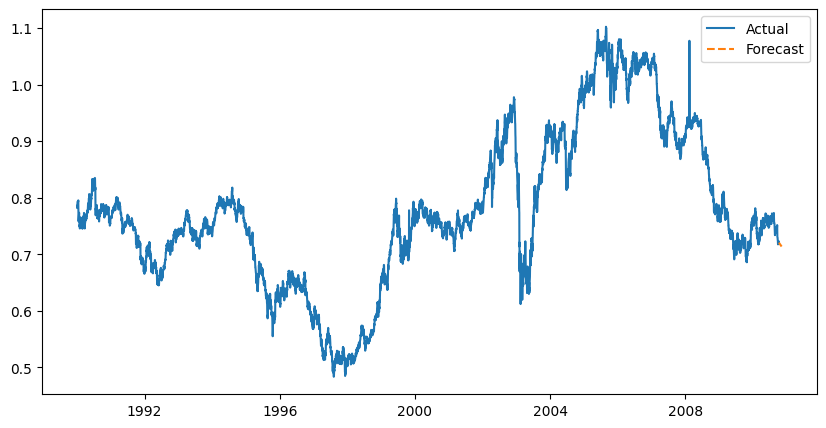

In [7]:

exp_model = Holt(df[column_name]).fit()
joblib.dump(exp_model, "models/exp_smoothing.pkl")

exp_forecast = exp_model.forecast(30)
exp_df = pd.DataFrame({"Forecast": exp_forecast})
exp_df.to_csv("results/forecasts/exp_smoothing_forecast.csv")

plt.figure(figsize=(10,5))
plt.plot(df[column_name], label="Actual")
plt.plot(exp_df["Forecast"], label="Forecast", linestyle="--")
plt.legend()
plt.savefig("results/plots/exp_smoothing_forecast.png")
plt.show()
plt.close()


## Model Evaluation

In [8]:

def mean_absolute_error(actual, predicted):
    return np.mean(np.abs(actual - predicted))

def root_mean_squared_error(actual, predicted):
    return np.sqrt(np.mean((actual - predicted) ** 2))

def mean_absolute_percentage_error(actual, predicted):
    actual = np.where(actual == 0, 1e-10, actual)
    return np.mean(np.abs((actual - predicted) / actual)) * 100


actual = df[column_name][-30:]

arima_metrics = {
    "MAE": float(mean_absolute_error(actual, arima_df["Forecast"])),
    "RMSE": float(root_mean_squared_error(actual, arima_df["Forecast"])),
    "MAPE (%)": float(mean_absolute_percentage_error(actual, arima_df["Forecast"]))
}

exp_metrics = {
    "MAE": float(mean_absolute_error(actual, exp_df["Forecast"])),
    "RMSE": float(root_mean_squared_error(actual, exp_df["Forecast"])),
    "MAPE (%)": float(mean_absolute_percentage_error(actual, exp_df["Forecast"]))
}

with open("results/metrics/arima_metrics.json", "w") as f:
    json.dump(arima_metrics, f, indent=4)

with open("results/metrics/exp_smoothing_metrics.json", "w") as f:
    json.dump(exp_metrics, f, indent=4)

print("ARIMA Metrics:", arima_metrics)
print("Exponential Smoothing Metrics:", exp_metrics)

print("\n")
print("Output is ready check the results/ directory for plots, forecasts, and metrics.")


ARIMA Metrics: {'MAE': nan, 'RMSE': nan, 'MAPE (%)': 1.7119209757079972}
Exponential Smoothing Metrics: {'MAE': nan, 'RMSE': nan, 'MAPE (%)': 2.1032649297516373}


Output is ready check the results/ directory for plots, forecasts, and metrics.
